# Kickstarter Pretty File
- In this notebook we will import the functions explored and laid out in our other two notebooks.
- Then we will use those functions to clean our data.
- We will then pass our cleaned data into a model that we define here in this notebook.
- Finally we will:
  - Explore our predictions
  - Explore our feature importances for future iterations
  - Create some visuals for our Dash app

## Importing
- Here we will import modules 
  - Including functions from our functions notebook
    - (Copied to the 'kick_func.py' module)
- Import the data we will use.

### Functions

In [1]:
import numpy as np 
import pandas as pd 
import os 
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import json
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import make_pipeline
import category_encoders as ce
from sklearn.impute import SimpleImputer
import eli5 # permutation imprtance
from eli5.sklearn import PermutationImportance
from xgboost import XGBClassifier
import shap
import nltk # Natural language
nltk.download('stopwords')
nltk.download('wordnet')
from bs4 import BeautifulSoup #to strip url
import string # for a list of puntuation
from nltk.corpus import stopwords 
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
import matplotlib.pyplot as plt
# %matplotlib inline
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Hakuj\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Hakuj\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
cd DataSets/Kickstarter/

[WinError 3] The system cannot find the path specified: 'DataSets/Kickstarter/'
C:\Users\Hakuj\Documents\DataSets\Kickstarter


In [3]:
from kick_func import *
"""Imports the models I designed in 'Cleaning' and wrote down in 'Functions'. 
    I am importing them from 'kick_func' as that is easier to do than importing from a notebook."""

"Imports the models I designed in 'Cleaning' and wrote down in 'Functions'. \n    I am importing them from 'kick_func' as that is easier to do than importing from a notebook."

### Data

In [4]:
train = get_a_year(2018)

C:\Users\Hakuj\Anaconda3\envs\Lambda_U2\lib\site-packages\pandas\core\frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


In [5]:
test = get_a_year(2019)

## Cleaning
- Get completed campaigns
- Drop Duplicates
- Convert datetime
 - Create new date columns
- Drop irrelevant columns
- Extract data from 'category' column
- Set target

Completed campaigns

In [6]:
train = completed_campaigns(train)

In [7]:
test = completed_campaigns(test)

Duplicates

In [8]:
train = drop_dupes(train)

In [9]:
test = drop_dupes(test)

Datetime Conversions

In [10]:
train = datetime_convert(train)

In [11]:
test = datetime_convert(test)

In [12]:
train = time_to_string(train)

In [13]:
test = time_to_string(test)

In [14]:
train.shape, test.shape #Have to drop ['unread_messages_count', 'unseen_activity_count'] from test

((208425, 48), (183562, 50))

In [15]:
test = test.drop(columns=['unread_messages_count', 'unseen_activity_count'])

In [16]:
train.shape, test.shape

((208425, 48), (183562, 48))

In [17]:
train = col_dict(train, 'category')

In [18]:
test = col_dict(test, 'category')

In [19]:
train.shape, test.shape

((208425, 54), (183562, 54))

In [5]:
X_train = train.drop(columns=['state','pledged', 'usd_pledged', 'state_changed_at', 'spotlight',
                     'converted_pledged_amount', 'source_url', 'backers_count', 'state',
                     'is_backing',	'is_starrable', 'is_starred', 'category_urls'])
y_train = train['state']

In [6]:
X_test = test.drop(columns=['state','pledged', 'usd_pledged', 'state_changed_at', 'spotlight',
                     'converted_pledged_amount', 'source_url', 'backers_count', 'state',
                     'is_backing',	'is_starrable', 'is_starred', 'category_urls'])
y_test = test['state']

## XGBoost
- Train the model
- Test the model
- Visualize the model

In [4]:
train = pd.read_csv('train2018.csv') #Alternative to above.
test = pd.read_csv('test2019.csv')

C:\Users\Hakuj\Anaconda3\envs\Lambda_U2\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (12,16,18,22) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [29]:
processor = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='most_frequent')
)

### Split and encode data

In [8]:
X_train, X_val,y_train, y_val = train_test_split(X_train, y_train, random_state=42)

In [30]:
X_train_processed = processor.fit_transform(X_train)
X_val_processed = processor.transform(X_val)

In [31]:
X_test_processed = processor.transform(X_test)

In [32]:
X_test_processed.shape, X_train_processed.shape, X_val_processed.shape

((183562, 42), (156318, 42), (52107, 42))

### Establish and train model

In [33]:
eval_set = [(X_train_processed, y_train), 
            (X_val_processed, y_val)]

model = XGBClassifier(n_estimators=1000, eval_set=eval_set, random_State=42, n_jobs=-1)

In [34]:
model.fit(X_train_processed, y_train, eval_set=eval_set, eval_metric='auc', 
          early_stopping_rounds=10)

[0]	validation_0-auc:0.80167	validation_1-auc:0.800038
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.802433	validation_1-auc:0.800752
[2]	validation_0-auc:0.81482	validation_1-auc:0.812649
[3]	validation_0-auc:0.816113	validation_1-auc:0.813888
[4]	validation_0-auc:0.820526	validation_1-auc:0.818156
[5]	validation_0-auc:0.82489	validation_1-auc:0.822223
[6]	validation_0-auc:0.835488	validation_1-auc:0.832935
[7]	validation_0-auc:0.835433	validation_1-auc:0.832801
[8]	validation_0-auc:0.837551	validation_1-auc:0.835335
[9]	validation_0-auc:0.839812	validation_1-auc:0.838009
[10]	validation_0-auc:0.839395	validation_1-auc:0.837396
[11]	validation_0-auc:0.840909	validation_1-auc:0.83911
[12]	validation_0-auc:0.841768	validation_1-auc:0.83976
[13]	validation_0-auc:0.848852	validation_1-auc:0.846508
[14]	validation_0-auc:0.850843	validation_1-auc:0.848473
[15

[141]	validation_0-auc:0.911175	validation_1-auc:0.906777
[142]	validation_0-auc:0.911407	validation_1-auc:0.907017
[143]	validation_0-auc:0.911463	validation_1-auc:0.907095
[144]	validation_0-auc:0.911604	validation_1-auc:0.907195
[145]	validation_0-auc:0.911761	validation_1-auc:0.907334
[146]	validation_0-auc:0.911913	validation_1-auc:0.907469
[147]	validation_0-auc:0.912035	validation_1-auc:0.90759
[148]	validation_0-auc:0.912061	validation_1-auc:0.907604
[149]	validation_0-auc:0.912132	validation_1-auc:0.907705
[150]	validation_0-auc:0.912457	validation_1-auc:0.908025
[151]	validation_0-auc:0.912553	validation_1-auc:0.908125
[152]	validation_0-auc:0.912609	validation_1-auc:0.908167
[153]	validation_0-auc:0.912685	validation_1-auc:0.908233
[154]	validation_0-auc:0.912746	validation_1-auc:0.908296
[155]	validation_0-auc:0.912866	validation_1-auc:0.908413
[156]	validation_0-auc:0.912925	validation_1-auc:0.908469
[157]	validation_0-auc:0.91312	validation_1-auc:0.908658
[158]	validation

[283]	validation_0-auc:0.922414	validation_1-auc:0.917711
[284]	validation_0-auc:0.922429	validation_1-auc:0.917738
[285]	validation_0-auc:0.922463	validation_1-auc:0.917778
[286]	validation_0-auc:0.922477	validation_1-auc:0.917784
[287]	validation_0-auc:0.922501	validation_1-auc:0.917806
[288]	validation_0-auc:0.922541	validation_1-auc:0.91785
[289]	validation_0-auc:0.922603	validation_1-auc:0.917909
[290]	validation_0-auc:0.92271	validation_1-auc:0.91803
[291]	validation_0-auc:0.92278	validation_1-auc:0.918133
[292]	validation_0-auc:0.922845	validation_1-auc:0.918212
[293]	validation_0-auc:0.922862	validation_1-auc:0.918225
[294]	validation_0-auc:0.922933	validation_1-auc:0.918295
[295]	validation_0-auc:0.922949	validation_1-auc:0.918294
[296]	validation_0-auc:0.922974	validation_1-auc:0.918329
[297]	validation_0-auc:0.923004	validation_1-auc:0.918359
[298]	validation_0-auc:0.923028	validation_1-auc:0.918385
[299]	validation_0-auc:0.923037	validation_1-auc:0.918392
[300]	validation_0

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1,
              eval_set=[(array([[1, 1, 1, ..., 307, 4, 1],
       [2, 1, 2, ..., 43, 17, 2],
       [3, 1, 3, ..., 33, 19, 3],
       ...,
       [155543, 1, 156253, ..., 46, 5, 30],
       [155544, 10, 156254, ..., 332, 2, 61],
       [155545, 1, 156255, ..., 15, 12, 26]], dtype=object),
                         75235     successful
117852    successful
68023     successful
110868    succ...
201285        failed
41369     successful
163617    successful
Name: state, Length: 52107, dtype: object)],
              gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=1000, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_State=42,
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=None, subsample=1, verbosity=1)

In [40]:
classification_report(y_test, (model.predict(X_test_processed)), output_dict=True)

{'failed': {'precision': 0.8049792531120332,
  'recall': 0.002462241401193045,
  'f1-score': 0.0049094659057838065,
  'support': 78790},
 'successful': {'precision': 0.5712657033291331,
  'recall': 0.9995514068644294,
  'f1-score': 0.727022176866498,
  'support': 104772},
 'accuracy': 0.5715725476950567,
 'macro avg': {'precision': 0.6881224782205831,
  'recall': 0.5010068241328113,
  'f1-score': 0.36596582138614087,
  'support': 183562},
 'weighted avg': {'precision': 0.6715821663628475,
  'recall': 0.5715725476950567,
  'f1-score': 0.41707098600676296,
  'support': 183562}}

In [41]:
pipeline = make_pipeline(
    processor,
    model
)

#MAKES a pipeline for pickling

In [42]:
# Test the pipeline
pipeline.predict(X_test_processed)

KeyError: 'blurb'

In [38]:
#Lets see how the model does with the test set
from sklearn.metrics import roc_auc_score
class_index = 1
y_pred_proba = model.predict_proba(X_test_processed)[:, class_index]
print(f'Test ROC AUC for class {class_index}:')
print(roc_auc_score(y_test, y_pred_proba))

Test ROC AUC for class 1:
0.6432994730331385


### Visuals!

In [18]:
explainer = shap.TreeExplainer(model)

In [39]:

row = X_val.iloc[[1]]


row_processed = processor.transform(row)
shap_values = explainer.shap_values(row_processed)

shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value, 
    shap_values=shap_values, 
    features=row
)

In [40]:
y_val.iloc[[1]]

8325    failed
Name: state, dtype: object

In [43]:
#Save above figure
shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value, 
    shap_values=shap_values, 
    features=row,
    show=False
)
plt.savefig('true_neg.png')

<Figure size 432x288 with 0 Axes>

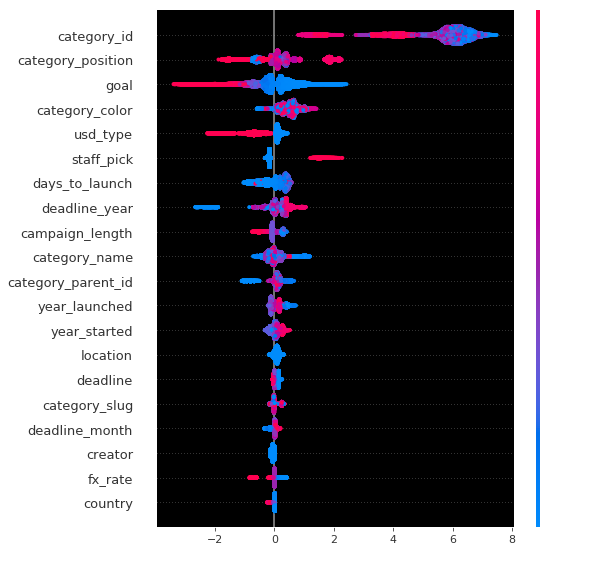

In [28]:
shap_values = explainer.shap_values(X_test_processed)
shap.initjs()
shap.summary_plot(shap_values, X_test_processed,feature_names=row.columns)


In [44]:
row = X_val.iloc[[2]]

row_processed = processor.transform(row)
shap_values = explainer.shap_values(row_processed)

shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value, 
    shap_values=shap_values, 
    features=row
)

In [45]:
y_val.iloc[[2]]

162839    failed
Name: state, dtype: object

In [48]:
# Want to save the above  plot
shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value, 
    shap_values=shap_values, 
    features=row,
    show=False
)
plt.savefig('false_pos.png')

<Figure size 432x288 with 0 Axes>

In [49]:
permuter = PermutationImportance(
    model,
    scoring='accuracy',
    n_iter=5,
    random_state=42
)
permuter.fit(X_val_processed, y_val)

PermutationImportance(cv='prefit',
                      estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                              colsample_bylevel=1,
                                              colsample_bynode=1,
                                              colsample_bytree=1,
                                              eval_set=[(array([[1, 1, 1, ..., 307, 4, 1],
       [2, 1, 2, ..., 43, 17, 2],
       [3, 1, 3, ..., 33, 19, 3],
       ...,
       [155543, 1, 156253, ..., 46, 5, 30],
       [155544, 10, 156254, ..., 332, 2, 61],
       [155545, 1, 156255, ..., 15, 12, 26]], dtype=object),
                                                         75235     success...
Name: state, Length: 52107, dtype: object)],
                                              gamma=0, learning_rate=0.1,
                                              max_delta_step=0, max_depth=3,
                                              min_child_weight=1, missing=None,
          

In [50]:
feature_names = X_val.columns.tolist()
pd.Series(permuter.feature_importances_, feature_names).sort_values(ascending=False)

category_id               0.150268
staff_pick                0.044102
goal                      0.040781
usd_type                  0.034517
deadline_year             0.019264
category_position         0.018450
days_to_launch            0.012409
category_name             0.010962
category_parent_id        0.009557
year_launched             0.009546
category_color            0.009427
campaign_length           0.007343
year_started              0.003673
fx_rate                   0.001125
category_slug             0.000714
location                  0.000599
deadline_month            0.000468
country                   0.000376
static_usd_rate           0.000180
day_started               0.000150
currency                  0.000046
month_launched            0.000027
creator                   0.000015
launched_at               0.000004
created_at                0.000000
currency_symbol           0.000000
currency_trailing_code    0.000000
current_currency          0.000000
disable_communicatio

In [53]:
eli5.show_weights(
    permuter, 
    top=None, # show permutation importances for all features
    feature_names=feature_names
)
# plt.savefig('bigimportances.png')

Weight,Feature
0.1503 ± 0.0023,category_id
0.0441 ± 0.0013,staff_pick
0.0408 ± 0.0013,goal
0.0345 ± 0.0025,usd_type
0.0193 ± 0.0003,deadline_year
0.0185 ± 0.0021,category_position
0.0124 ± 0.0009,days_to_launch
0.0110 ± 0.0015,category_name
0.0096 ± 0.0005,category_parent_id
0.0095 ± 0.0012,year_launched


In [37]:
model.predict(X_test_processed)

array(['successful', 'successful', 'successful', ..., 'successful',
       'successful', 'successful'], dtype=object)

In [38]:
row = X_test.iloc[[2]]

explainer = shap.TreeExplainer(model)
row_processed = processor.transform(row)
shap_values = explainer.shap_values(row_processed)

shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value, 
    shap_values=shap_values, 
    features=row
)

In [39]:
pipeline.predict(X_test)

array(['successful', 'successful', 'successful', ..., 'successful',
       'successful', 'successful'], dtype=object)

## To pickle
- here is the model that we will pickle!
  - The first one we made has too many features
  - a lot are useless, others are redundent.

In [9]:
X_train_simplr = X_train.drop(columns = ['deadline', 'blurb', 'urls', 'profile','photo','permissions','id','friends','disable_communication', 'slug', 
                     'currency_trailing_code', 'currency_symbol', 'current_currency',
                     'created_at', 'deadline day', 'name', 'launched_at', 'creator', 'fx_rate',
                      'category_color', 'staff_pick', 'location', 'category_position','currency', 'day_started',
                       'category_parent_id','category_id', 'static_usd_rate', 'category_slug', 'usd_type'])
X_test_simplr = X_test.drop(columns = ['deadline', 'blurb', 'urls', 'profile','photo','permissions','id','friends','disable_communication', 'slug', 
                     'currency_trailing_code', 'currency_symbol', 'current_currency',
                     'created_at', 'deadline day', 'name', 'launched_at', 'creator', 'fx_rate',
                      'category_color', 'staff_pick', 'location', 'category_position','currency', 'day_started',
                       'category_parent_id','category_id', 'static_usd_rate', 'category_slug', 'usd_type'])
X_val_simplr = X_val.drop(columns = ['deadline', 'blurb', 'urls', 'profile','photo','permissions','id','friends','disable_communication', 'slug', 
                     'currency_trailing_code', 'currency_symbol', 'current_currency',
                     'created_at', 'deadline day', 'name', 'launched_at', 'creator', 'fx_rate',
                      'category_color', 'staff_pick', 'location', 'category_position','currency', 'day_started',
                       'category_parent_id','category_id', 'static_usd_rate', 'category_slug', 'usd_type'])

In [10]:
processor2 = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='most_frequent')
)

In [11]:
X_train_simplr_p = processor2.fit_transform(X_train_simplr)
X_val_simplr_p = processor2.transform(X_val_simplr)
X_test_simplr_p = processor2.transform(X_test_simplr)

In [12]:
eval_set2 = [(X_train_simplr_p, y_train), (X_val_simplr_p, y_val)]

model2 = XGBClassifier(n_estimators=2000, eval_set=eval_set2, random_State=42, n_jobs=-1)

In [13]:
model2.fit(X_train_simplr_p, y_train, eval_set=eval_set2, eval_metric='auc', 
          early_stopping_rounds=10)

[0]	validation_0-auc:0.707108	validation_1-auc:0.70296
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.708113	validation_1-auc:0.703835
[2]	validation_0-auc:0.72391	validation_1-auc:0.719239
[3]	validation_0-auc:0.726871	validation_1-auc:0.722045
[4]	validation_0-auc:0.729307	validation_1-auc:0.723956
[5]	validation_0-auc:0.7334	validation_1-auc:0.728594
[6]	validation_0-auc:0.738485	validation_1-auc:0.733913
[7]	validation_0-auc:0.738348	validation_1-auc:0.733674
[8]	validation_0-auc:0.74179	validation_1-auc:0.737331
[9]	validation_0-auc:0.746161	validation_1-auc:0.74189
[10]	validation_0-auc:0.748343	validation_1-auc:0.744193
[11]	validation_0-auc:0.750843	validation_1-auc:0.746681
[12]	validation_0-auc:0.752746	validation_1-auc:0.748645
[13]	validation_0-auc:0.757532	validation_1-auc:0.753524
[14]	validation_0-auc:0.759121	validation_1-auc:0.754905
[15]

[142]	validation_0-auc:0.861195	validation_1-auc:0.857573
[143]	validation_0-auc:0.861535	validation_1-auc:0.857874
[144]	validation_0-auc:0.861631	validation_1-auc:0.857982
[145]	validation_0-auc:0.86176	validation_1-auc:0.858133
[146]	validation_0-auc:0.861862	validation_1-auc:0.858235
[147]	validation_0-auc:0.8621	validation_1-auc:0.858487
[148]	validation_0-auc:0.86226	validation_1-auc:0.858652
[149]	validation_0-auc:0.863051	validation_1-auc:0.859443
[150]	validation_0-auc:0.863106	validation_1-auc:0.85949
[151]	validation_0-auc:0.863123	validation_1-auc:0.85949
[152]	validation_0-auc:0.863609	validation_1-auc:0.860012
[153]	validation_0-auc:0.863661	validation_1-auc:0.860052
[154]	validation_0-auc:0.863914	validation_1-auc:0.86028
[155]	validation_0-auc:0.864514	validation_1-auc:0.860877
[156]	validation_0-auc:0.864958	validation_1-auc:0.861306
[157]	validation_0-auc:0.865644	validation_1-auc:0.862012
[158]	validation_0-auc:0.865669	validation_1-auc:0.862029
[159]	validation_0-au

[284]	validation_0-auc:0.883145	validation_1-auc:0.879553
[285]	validation_0-auc:0.883153	validation_1-auc:0.879559
[286]	validation_0-auc:0.883251	validation_1-auc:0.879644
[287]	validation_0-auc:0.88336	validation_1-auc:0.879794
[288]	validation_0-auc:0.883564	validation_1-auc:0.88002
[289]	validation_0-auc:0.883667	validation_1-auc:0.880119
[290]	validation_0-auc:0.883689	validation_1-auc:0.880137
[291]	validation_0-auc:0.883723	validation_1-auc:0.880169
[292]	validation_0-auc:0.883758	validation_1-auc:0.880204
[293]	validation_0-auc:0.883798	validation_1-auc:0.880215
[294]	validation_0-auc:0.883826	validation_1-auc:0.880245
[295]	validation_0-auc:0.883824	validation_1-auc:0.880234
[296]	validation_0-auc:0.883909	validation_1-auc:0.880358
[297]	validation_0-auc:0.884093	validation_1-auc:0.88056
[298]	validation_0-auc:0.884148	validation_1-auc:0.880602
[299]	validation_0-auc:0.884226	validation_1-auc:0.880701
[300]	validation_0-auc:0.884249	validation_1-auc:0.880719
[301]	validation_

[426]	validation_0-auc:0.890783	validation_1-auc:0.887055
[427]	validation_0-auc:0.890808	validation_1-auc:0.887074
[428]	validation_0-auc:0.890858	validation_1-auc:0.887123
[429]	validation_0-auc:0.890881	validation_1-auc:0.887141
[430]	validation_0-auc:0.89093	validation_1-auc:0.887189
[431]	validation_0-auc:0.890999	validation_1-auc:0.887274
[432]	validation_0-auc:0.891011	validation_1-auc:0.887284
[433]	validation_0-auc:0.891025	validation_1-auc:0.88731
[434]	validation_0-auc:0.891038	validation_1-auc:0.887319
[435]	validation_0-auc:0.891053	validation_1-auc:0.887337
[436]	validation_0-auc:0.89106	validation_1-auc:0.887337
[437]	validation_0-auc:0.891103	validation_1-auc:0.887366
[438]	validation_0-auc:0.891168	validation_1-auc:0.887428
[439]	validation_0-auc:0.891209	validation_1-auc:0.887471
[440]	validation_0-auc:0.891255	validation_1-auc:0.887505
[441]	validation_0-auc:0.891314	validation_1-auc:0.887563
[442]	validation_0-auc:0.891325	validation_1-auc:0.887569
[443]	validation_

[568]	validation_0-auc:0.894703	validation_1-auc:0.890516
[569]	validation_0-auc:0.894751	validation_1-auc:0.890569
[570]	validation_0-auc:0.89477	validation_1-auc:0.89057
[571]	validation_0-auc:0.894795	validation_1-auc:0.890608
[572]	validation_0-auc:0.894806	validation_1-auc:0.890611
[573]	validation_0-auc:0.89481	validation_1-auc:0.890617
[574]	validation_0-auc:0.894814	validation_1-auc:0.890621
[575]	validation_0-auc:0.894825	validation_1-auc:0.890624
[576]	validation_0-auc:0.89485	validation_1-auc:0.890647
[577]	validation_0-auc:0.894856	validation_1-auc:0.890647
[578]	validation_0-auc:0.894888	validation_1-auc:0.890681
[579]	validation_0-auc:0.894913	validation_1-auc:0.890699
[580]	validation_0-auc:0.894926	validation_1-auc:0.890725
[581]	validation_0-auc:0.89495	validation_1-auc:0.890745
[582]	validation_0-auc:0.89501	validation_1-auc:0.890813
[583]	validation_0-auc:0.895057	validation_1-auc:0.89087
[584]	validation_0-auc:0.895083	validation_1-auc:0.890903
[585]	validation_0-au

[710]	validation_0-auc:0.897185	validation_1-auc:0.892529
[711]	validation_0-auc:0.897206	validation_1-auc:0.892548
[712]	validation_0-auc:0.897222	validation_1-auc:0.89256
[713]	validation_0-auc:0.897241	validation_1-auc:0.892572
[714]	validation_0-auc:0.897268	validation_1-auc:0.892602
[715]	validation_0-auc:0.897288	validation_1-auc:0.892622
[716]	validation_0-auc:0.897307	validation_1-auc:0.892646
[717]	validation_0-auc:0.89732	validation_1-auc:0.892662
[718]	validation_0-auc:0.897339	validation_1-auc:0.892682
[719]	validation_0-auc:0.897355	validation_1-auc:0.892693
[720]	validation_0-auc:0.897372	validation_1-auc:0.892708
[721]	validation_0-auc:0.897381	validation_1-auc:0.892711
[722]	validation_0-auc:0.897394	validation_1-auc:0.892713
[723]	validation_0-auc:0.89742	validation_1-auc:0.892739
[724]	validation_0-auc:0.897426	validation_1-auc:0.892735
[725]	validation_0-auc:0.897437	validation_1-auc:0.892739
[726]	validation_0-auc:0.897445	validation_1-auc:0.892755
[727]	validation_

[852]	validation_0-auc:0.89886	validation_1-auc:0.89364
[853]	validation_0-auc:0.898869	validation_1-auc:0.893638
[854]	validation_0-auc:0.898873	validation_1-auc:0.893638
[855]	validation_0-auc:0.89888	validation_1-auc:0.893641
[856]	validation_0-auc:0.898883	validation_1-auc:0.893636
[857]	validation_0-auc:0.898889	validation_1-auc:0.893638
[858]	validation_0-auc:0.898901	validation_1-auc:0.893644
[859]	validation_0-auc:0.898911	validation_1-auc:0.893646
[860]	validation_0-auc:0.898918	validation_1-auc:0.89366
[861]	validation_0-auc:0.89893	validation_1-auc:0.893661
[862]	validation_0-auc:0.898936	validation_1-auc:0.893662
[863]	validation_0-auc:0.898949	validation_1-auc:0.893675
[864]	validation_0-auc:0.898969	validation_1-auc:0.893689
[865]	validation_0-auc:0.898975	validation_1-auc:0.893695
[866]	validation_0-auc:0.89899	validation_1-auc:0.893699
[867]	validation_0-auc:0.899003	validation_1-auc:0.893708
[868]	validation_0-auc:0.899014	validation_1-auc:0.893714
[869]	validation_0-a

[994]	validation_0-auc:0.900677	validation_1-auc:0.89494
[995]	validation_0-auc:0.900683	validation_1-auc:0.894939
[996]	validation_0-auc:0.900684	validation_1-auc:0.89494
[997]	validation_0-auc:0.900694	validation_1-auc:0.894942
[998]	validation_0-auc:0.900705	validation_1-auc:0.894936
[999]	validation_0-auc:0.900712	validation_1-auc:0.894934
[1000]	validation_0-auc:0.900722	validation_1-auc:0.894935
[1001]	validation_0-auc:0.900724	validation_1-auc:0.894931
[1002]	validation_0-auc:0.900735	validation_1-auc:0.894936
[1003]	validation_0-auc:0.900739	validation_1-auc:0.894941
[1004]	validation_0-auc:0.90075	validation_1-auc:0.894931
[1005]	validation_0-auc:0.900756	validation_1-auc:0.894933
[1006]	validation_0-auc:0.900762	validation_1-auc:0.894936
[1007]	validation_0-auc:0.900776	validation_1-auc:0.894951
[1008]	validation_0-auc:0.90078	validation_1-auc:0.894952
[1009]	validation_0-auc:0.900791	validation_1-auc:0.894955
[1010]	validation_0-auc:0.900801	validation_1-auc:0.894964
[1011]	

[1134]	validation_0-auc:0.901909	validation_1-auc:0.895654
[1135]	validation_0-auc:0.90192	validation_1-auc:0.895661
[1136]	validation_0-auc:0.901936	validation_1-auc:0.895664
[1137]	validation_0-auc:0.901955	validation_1-auc:0.895673
[1138]	validation_0-auc:0.901969	validation_1-auc:0.895684
[1139]	validation_0-auc:0.901972	validation_1-auc:0.89568
[1140]	validation_0-auc:0.901981	validation_1-auc:0.89568
[1141]	validation_0-auc:0.901998	validation_1-auc:0.895701
[1142]	validation_0-auc:0.902003	validation_1-auc:0.895702
[1143]	validation_0-auc:0.902011	validation_1-auc:0.895704
[1144]	validation_0-auc:0.902019	validation_1-auc:0.895712
[1145]	validation_0-auc:0.902026	validation_1-auc:0.895709
[1146]	validation_0-auc:0.902029	validation_1-auc:0.895708
[1147]	validation_0-auc:0.902043	validation_1-auc:0.895714
[1148]	validation_0-auc:0.90205	validation_1-auc:0.895717
[1149]	validation_0-auc:0.902065	validation_1-auc:0.895729
[1150]	validation_0-auc:0.90207	validation_1-auc:0.89573
[11

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1,
              eval_set=[(array([[1.00e+00, 1.00e+04, 3.00e+00, ..., 9.60e+01, 2.00e+01, 1.00e+00],
       [1.00e+00, 1.00e+03, 4.00e+00, ..., 1.60e+01, 3.00e+01, 2.00e+00],
       [1.00e+00, 1.00e+03, 8.00e+00, ..., 0.00e+00, 6.00e+01, 3.00e+00],
       ...,
       [1.00e+00, 5.00e+02, 6.00e+00, ..., 1.24e+02, 4.4...
201285        failed
41369     successful
163617    successful
Name: state, Length: 52107, dtype: object)],
              gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=2000, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_State=42,
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=None, subsample=1, verbosity=1)

## Visuals


In [14]:
permuter2 = PermutationImportance(
    model2,
    scoring='accuracy',
    n_iter=5,
    random_state=42
)
permuter2.fit(X_val_simplr_p, y_val)
feature_names = X_val_simplr.columns.tolist()
pd.Series(permuter2.feature_importances_, feature_names).sort_values(ascending=False)
eli5.show_weights(
    permuter2, 
    top=None, # schow permutation importances for all features
    feature_names=feature_names,
    
) 
# plt.savefig('small_importances.png')

Weight,Feature
0.1808 ± 0.0013,category_name
0.0409 ± 0.0016,goal
0.0220 ± 0.0020,days_to_launch
0.0152 ± 0.0019,campaign_length
0.0083 ± 0.0015,year_launched
0.0064 ± 0.0012,deadline_year
0.0063 ± 0.0002,year_started
0.0037 ± 0.0007,country
0.0019 ± 0.0006,month_started
0.0011 ± 0.0005,deadline_month


In [15]:
eli5.show_weights(
    permuter2, 
    top=None, # schow permutation importances for all features
    feature_names=feature_names,
    
) 
# plt.savefig('small_importances.png')

Weight,Feature
0.1808 ± 0.0013,category_name
0.0409 ± 0.0016,goal
0.0220 ± 0.0020,days_to_launch
0.0152 ± 0.0019,campaign_length
0.0083 ± 0.0015,year_launched
0.0064 ± 0.0012,deadline_year
0.0063 ± 0.0002,year_started
0.0037 ± 0.0007,country
0.0019 ± 0.0006,month_started
0.0011 ± 0.0005,deadline_month


In [16]:
# This pipeline captures the fit encoder and model so we can pickle it.
pipeline2 = make_pipeline(
    processor2,
    model2
)

In [17]:
test_pred = pipeline2.predict(X_test_simplr)

In [18]:
row = X_test_simplr.iloc[[2]]

explainer = shap.TreeExplainer(model2)
row_processed = processor2.transform(row)
shap_values = explainer.shap_values(row_processed)

shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value, 
    shap_values=shap_values, 
    features=row,
    
)

In [19]:
y_test.iloc[[2]]

2    failed
Name: state, dtype: object

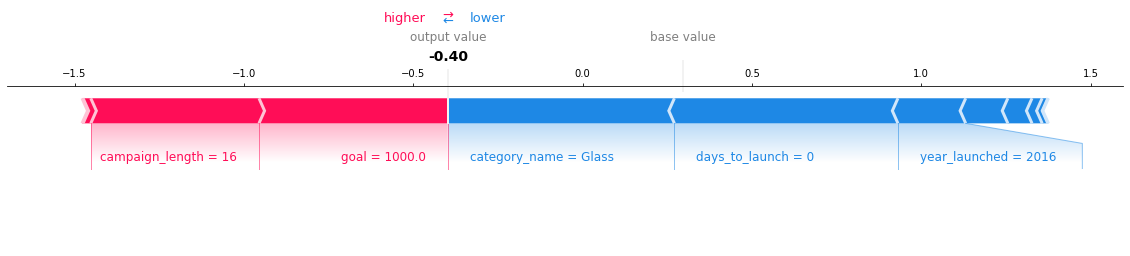

In [25]:
row = X_test_simplr.iloc[[0]]

explainer = shap.TreeExplainer(model2)
row_processed = processor2.transform(row)
shap_values = explainer.shap_values(row_processed)

shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value, 
    shap_values=shap_values, 
    features=row,
    matplotlib=True
)

In [21]:
y_test.iloc[[0]]

0    failed
Name: state, dtype: object

In [22]:
row = X_test_simplr.iloc[[55]]

explainer = shap.TreeExplainer(model2)
row_processed = processor2.transform(row)
shap_values = explainer.shap_values(row_processed)

shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value, 
    shap_values=shap_values, 
    features=row
)

In [23]:
y_test.iloc[[55]]

55    successful
Name: state, dtype: object

In [25]:
classification_report(y_test,test_pred, output_dict=True)

{'failed': {'precision': 0.7267697048935375,
  'recall': 0.7901764183271989,
  'f1-score': 0.7571478954601286,
  'support': 78790},
 'successful': {'precision': 0.83113036017079,
  'recall': 0.776600618485855,
  'f1-score': 0.8029407411062318,
  'support': 104772},
 'accuracy': 0.7824277355879757,
 'macro avg': {'precision': 0.7789500325321638,
  'recall': 0.783388518406527,
  'f1-score': 0.7800443182831802,
  'support': 183562},
 'weighted avg': {'precision': 0.7863358164782245,
  'recall': 0.7824277355879757,
  'f1-score': 0.7832851571157737,
  'support': 183562}}

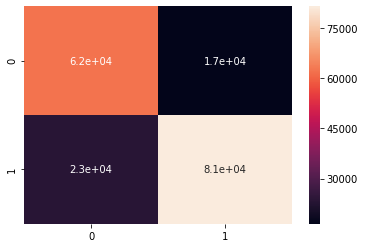

In [27]:
sns.heatmap(confusion_matrix(y_test,test_pred), annot=True)

In [ ]:
pipeline2.

## Dash app nonsense
- Here is where I scribble to get things for my dash app
  - comletey defeating the purpose of this 'pretty' notebook.
- There was a lot more here, but I removed it and now I wish I hadn't.
   - So, now the rest stays.
 - Like dict comprehensions to save time.
 


In [86]:
from joblib import dump
dump(pipeline2, 'pipeline.joblib', compress=True)

In [88]:
import joblib
import sklearn
print(f'joblib=={joblib.__version__}')
print(f'scikit-learn=={sklearn.__version__}')
print(f'category_encoders=={ce.__version__}')

joblib==0.13.2
scikit-learn==0.21.3
category_encoders==2.0.0


In [116]:
X_train_simplr['category_name'].value_counts().index.sort_values()

Index(['3D Printing', 'Academic', 'Accessories', 'Action', 'Animals', 'Animation', 'Anthologies', 'Apparel', 'Apps', 'Architecture',
       ...
       'Wearables', 'Weaving', 'Web', 'Webcomics', 'Webseries', 'Woodworking', 'Workshops', 'World Music', 'Young Adult', 'Zines'], dtype='object', length=159)

In [119]:
X_test_simplr.columns

Index(['country', 'goal', 'month_started', 'year_started', 'month_launched', 'day_launched', 'year_launched', 'deadline_month', 'deadline_year', 'days_to_launch', 'campaign_length', 'category_name'], dtype='object')

In [27]:
import plotly.express as px

In [ ]:
px.l